In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


import unicodedata
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import itertools
from scipy import stats
from scipy.spatial.distance import pdist, squareform 
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib
from IPython.display import HTML, display
from sklearn.decomposition import NMF

In [2]:
df = pd.read_json('../data/lyrics_cleaned.json')

In [3]:
df.reset_index(drop=True, inplace=True)

In [4]:
# let's check out a random song
idx = np.random.randint(0,6252)
print(df.iloc[idx, 0], '-', df.iloc[idx, 1], '\n', 
      '--------------',
      '\n', df.iloc[idx, 2])

Ciara Featuring Ludacris - Ride 
 -------------- 
 (feat. Ludacris)  [Ciara:]  Uh-huh   [Intro:]  Catch me in the mall  You know I buy it out.  G5 planes, yeah I fly it out.  N-gga in the back look like lex  In them 28's and  Oh you can't get her if  Ain't got plenty cake.  ATL Georgia, bodies  Look like this size  23 waist, pretty face  Thick thighs.  [Ciara:]  I can do it big  I can do it long  I can do whenever or however  You want  I can do it up and down  I can do circles  To him I'm a gymnast  This one is my circus  [Chorus:]  I mark it so good  They can't wait til you try  Me  I work it so good  Man, these n-ggas  Tryna buy I I I I me  They love they way I ride it [x3]  They love the way I ride the beat  How I ride the beat, I ride it  They love they way I ride it [x3]  They love the way I ride the beat  Like a motherf-cking freak  And I won't stop, don't stop  Get it! Get it!  I'm a pitch down the middle  Baby hit it! hit it!  I do it tonight  Handle my business, like a big gir

In [46]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform(df['lyrics'])
features = vectorizer.get_feature_names()

In [47]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [48]:
top_centroids = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]
print("\n3) top features (words) for each cluster:")
for num, centroid in enumerate(top_centroids):
    print("%d: %s" % (num, ", ".join(features[i] for i in centroid)))


3) top features (words) for each cluster:
0: don, baby, know, wanna, just, want, ll, like, let, girl
1: like, just, ll, ve, yeah, know, got, love, time, don
2: like, nigga, got, yeah, bitch, ain, shit, fuck, ya, niggas
3: oh, yeah, baby, like, know, love, don, want, let, ooh
4: love, baby, know, ll, don, heart, just, way, need, like
5: la, love, like, baby, don, lala, oh, just, ooh, cause


**Not really useful outputs. Contractions are being split and shouldn't be. Too many words are common across all found topics. Need to adjust the stopwords a bit. Might find some value in increasing n-grams.**

In [8]:
vectorizer = TfidfVectorizer(stop_words='english', 
                             max_features=10000)
X = vectorizer.fit_transform(df['lyrics'])
features = vectorizer.get_feature_names()

In [9]:
top_idxs = np.argsort(vectorizer.idf_)[::-1]
bottom_idxs = np.argsort(vectorizer.idf_)[::]

In [10]:
features = vectorizer.get_feature_names()

In [11]:
bottom_100_words = [features[i] for i in bottom_idxs[:100]]

In [12]:
bottom_100_words

['know',
 'just',
 'like',
 'don',
 'got',
 'love',
 'll',
 'cause',
 'let',
 'time',
 'yeah',
 'baby',
 'make',
 'say',
 'oh',
 'way',
 'right',
 'want',
 'ain',
 'come',
 'wanna',
 've',
 'girl',
 'tell',
 'need',
 'feel',
 'think',
 'life',
 'night',
 'man',
 'good',
 'gonna',
 'look',
 'heart',
 'said',
 'day',
 'little',
 'gotta',
 'world',
 'away',
 'won',
 'mind',
 'chorus',
 'eyes',
 'ya',
 'long',
 'things',
 'thing',
 'better',
 'really',
 'hold',
 'home',
 'leave',
 'real',
 'shit',
 'stop',
 'em',
 'head',
 'turn',
 'hard',
 'hit',
 'stay',
 'boy',
 'hey',
 'new',
 'money',
 'bout',
 'did',
 'try',
 'gone',
 'hear',
 'left',
 'face',
 'play',
 'nigga',
 'tonight',
 'big',
 'fuck',
 'thought',
 'believe',
 'bad',
 'run',
 'told',
 'talk',
 'wrong',
 'gon',
 'live',
 'high',
 'going',
 'bitch',
 'inside',
 'crazy',
 'old',
 'yo',
 'break',
 'hand',
 'came',
 'feeling',
 'walk',
 'fall']

In [13]:
from nltk.corpus import stopwords
lyric_stopwords = set(stopwords.words('english') + bottom_100_words)

In [14]:
vectorizer = TfidfVectorizer(stop_words=list(lyric_stopwords), 
                             max_features=5000, 
                             ngram_range=(2,5))
X = vectorizer.fit_transform(df['lyrics'])
features = vectorizer.get_feature_names()

In [24]:
def fit_nmf(r, data):
    nmf = NMF(n_components=r, init='random', random_state=0)
    nmf.fit(data)
    W = nmf.transform(data)
    H = nmf.components_
    return nmf.reconstruction_err_

Text(0, 0.5, 'Reconstruction Errror')

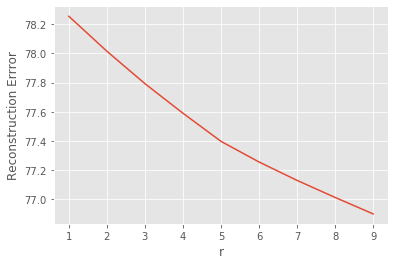

In [16]:
range_size = range(1, 10)
error = [fit_nmf(i, X) for i in range_size]
plt.plot(range_size, error)
plt.xticks(range_size)
plt.xlabel('r')
plt.ylabel('Reconstruction Errror')

Starting to see an elbow at n_components=5 with n_grams ranging from 2-10. But the reconstruction error is still really high.

**Try just looking at few artists at first**

In [ ]:
df.groupby('artist').count().sort_values(by='title', ascending=False).head(20)

In [17]:
eminem_chesney = df[(df['artist'] == 'Eminem') | (df['artist'] == 'Kenny Chesney')]

In [18]:
eminem_chesney

,artist,title,lyrics,character_count,word_count
65,Kenny Chesney,Here And Now,Seen the skyline of New York City Fireflies i...,1642,309
84,Eminem,Darkness,"I don't wanna be alone, I don't wanna be I do...",4793,896
114,Eminem,Premonition (Intro),"Yeah So I guess this is what it is, huh? Thi...",2865,576
117,Eminem,In Too Deep,"""This could never work,"" is what we said at fi...",2984,568
124,Eminem,Marsh,"My name is Marsh and this world, I'm out of it...",4139,775
...,...,...,...,...,...
5147,Kenny Chesney,She Thinks My Tractor's Sexy,(Paul Overstreet/Jim Collins) Plowin' these f...,1710,327
5182,Kenny Chesney,You Had Me From Hello,"(Kenny Chesney/Skip Ewing) One word, that's a...",1185,241
5258,Kenny Chesney,How Forever Feels,(Tony Mullins/Wendell Mobley) Big orange ball...,1077,197
5339,Eminem,My Name Is,"Hi, my name is, what? My name is, who? My nam...",3963,778


In [65]:
vectorizer = TfidfVectorizer(stop_words='english', 
                             max_features=5000, 
                             ngram_range=(1,3))
X = vectorizer.fit_transform(eminem_chesney['lyrics'])
features = vectorizer.get_feature_names()

Text(0, 0.5, 'Reconstruction Errror')

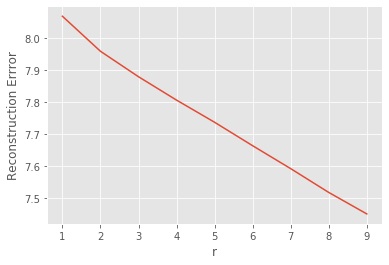

In [66]:
range_size = range(1, 10)
error = [fit_nmf(i, X) for i in range_size]
plt.plot(range_size, error)
plt.xticks(range_size)
plt.xlabel('r')
plt.ylabel('Reconstruction Errror')

In [78]:
model = NMF(n_components=2, init='random', random_state=0)
W = model.fit_transform(X)
H = model.components_

In [79]:
model.reconstruction_err_

7.958975664685379

In [69]:
def hand_label_topics(H, vocabulary):
    '''
    Print the most influential words of each latent topic, and prompt the user
    to label each topic. The user should use their humanness to figure out what
    each latent topic is capturing.
    '''
    hand_labels = []
    for i, row in enumerate(H):
        top_five = np.argsort(row)[::-1][:10]
        print('topic', i)
        print('-->', ' '.join(vocabulary[top_five]))
#         label = input('please label this topic: ')
#         hand_labels.append(label)
#         print()
    return hand_labels

In [80]:
features = np.array(features)
hand_label_topics(H, features)

topic 0
--> meant mama closet cleanin meant hurt meant meant make mama meant hurt mama meant sorry mama meant tonight cleanin closet
topic 1
--> like just cause don ll know got say said yeah


[]

## Let's build a vectorizer from scratch!

In [ ]:
def lyric_tokenizer():
    

In [43]:
from nltk.util import ngrams
from nl
def get_word_list(text):
    result = text.lower().split()
    # square brackets signify who is speaking/singing
    result = [w for w in result if (w.startswith('[') and w.endswith(']')) != True]
    
    return result

In [44]:
# text = df.iloc[np.random.randint(0,6252), 2]

In [45]:
get_word_list(text)

['uh',
 'huh',
 'yea,',
 'yeah',
 'duro!',
 'you',
 'gotta',
 'let',
 'it',
 'bump',
 'uh,',
 'uh,',
 'uh',
 'like',
 'dat',
 'yeah',
 'come',
 'on',
 'bring',
 'the',
 'chorus',
 'in',
 '1',
 '-',
 "i'd",
 'risk',
 'everything',
 'for',
 'one',
 'kiss,',
 'everything',
 'yes',
 "i'd",
 'do',
 'anything',
 '(anything?)',
 'anything',
 'for',
 'you',
 "i'd",
 'do',
 'a',
 'bid,',
 'loose',
 'a',
 'rib,',
 'bust',
 'a',
 'cap,',
 "trustin'",
 'that',
 'run',
 'up',
 'to',
 'heaven',
 'doors,',
 'exchange',
 'my',
 'life',
 'for',
 'yours',
 'leave',
 'a',
 'steak',
 'out',
 'the',
 'door,',
 'mi',
 'casa,',
 'su',
 'casa',
 'just',
 'remember',
 'to',
 'turn',
 'the',
 'lights',
 'off',
 'in',
 'the',
 'hall',
 'my',
 'brother',
 'from',
 'anotha',
 'pop,',
 'minus',
 'one',
 'shot',
 'we',
 'neno',
 'and',
 'g-money',
 'man,',
 'we',
 'all',
 'we',
 'got',
 'from',
 'the',
 'stoop',
 'to',
 'the',
 'big',
 'dudes,',
 "stoppin'",
 'us',
 'from',
 "playin'",
 'hoops',
 'and',
 'us',
 'get